In [1]:
# This source code is provided for the purposes of scientific reproducibility
# under the following limited license from Element AI Inc. The code is an
# implementation of the N-BEATS model (Oreshkin et al., N-BEATS: Neural basis
# expansion analysis for interpretable time series forecasting,
# https://arxiv.org/abs/1905.10437). The copyright to the source code is
# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/.  Any commercial use (whether
# for the benefit of third parties or internally in production) requires an
# explicit license. The subject-matter of the N-BEATS model and associated
# materials are the property of Element AI Inc. and may be subject to patent
# protection. No license to patents is granted hereunder (whether express or
# implied). Copyright © 2020 Element AI Inc. All rights reserved.

"""
M4 Experiment
"""
import logging
import os
from typing import Dict

import gin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as t
from fire import Fire
import pickle

from common.experiment import Experiment
from common.sampler import TimeseriesSampler
from common.torch.ops import to_tensor
from common.torch.snapshots import SnapshotManager
from datasets.m4 import M4Dataset, M4Meta
from experiments.trainer import trainer
from experiments.model import generic, interpretable
from summary.utils import group_values

## Dataset load
- M4 dataset: 100,000 time-series
- 'Daily': 4227, 'Hourly': 414, 'Monthly': 48000, 'Quarterly': 24000, 'Weekly': 359, 'Yearly': 23000
- Horizon: 6,  8, 13, 14, 18, 48

In [2]:
# M4Dataset.download()
# dataset = M4Dataset.load(training=True)

In [9]:
# data = {
#     'ids': dataset.ids,
#     'groups': dataset.groups,
#     'frequencies': dataset.frequencies,
#     'horizons': dataset.horizons,
#     'values': dataset.values
# }

# with open('M4Dataset.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [9]:
with open('dataset/nbeats/M4Dataset.pkl', 'rb') as f:
    data = pickle.load(f)

ids = data['ids']
groups = data['groups']
frequencies = data['frequencies']
horizons = data['horizons']
values = data['values']

In [17]:
len(values)

100000

In [19]:
unique_values, counts = np.unique(groups, return_counts=True)
count_dict = dict(zip(unique_values, counts))
print(count_dict)

{'Daily': 4227, 'Hourly': 414, 'Monthly': 48000, 'Quarterly': 24000, 'Weekly': 359, 'Yearly': 23000}


In [21]:
np.unique(horizons)

array([ 6,  8, 13, 14, 18, 48])

### Training 

In [2]:
class M4Experiment(Experiment):
    @gin.configurable()
    def instance(self,
                 repeat: int,
                 lookback: int,
                 loss: str,
                 history_size: Dict[str, float],
                 iterations: Dict[str, int],
                 model_type: str):

        with open('M4Dataset.pkl', 'rb') as f:  #dataset/nbeats/
            dataset = pickle.load(f)

        forecasts = []
        for seasonal_pattern in M4Meta.seasonal_patterns:
            history_size_in_horizons = history_size[seasonal_pattern]
            horizon = M4Meta.horizons_map[seasonal_pattern]
            input_size = lookback * horizon
            print(seasonal_pattern, 'lookback', input_size, 'horizon', horizon)

            # Training Set
            training_values = group_values(dataset['values'], dataset['groups'], seasonal_pattern)

            training_set = TimeseriesSampler(timeseries=training_values,
                                             insample_size=input_size,
                                             outsample_size=horizon,
                                             window_sampling_limit=int(history_size_in_horizons * horizon))

            if model_type == 'interpretable':
                model = interpretable(input_size=input_size, output_size=horizon)
            elif model_type == 'generic':
                model = generic(input_size=input_size, output_size=horizon)
            else:
                raise Exception(f'Unknown model type {model_type}')

            # Train model
            snapshot_dir = os.path.join(self.root, f'snapshots_{model_type}', seasonal_pattern)
            snapshot_manager = SnapshotManager(snapshot_dir=snapshot_dir, total_iterations=iterations[seasonal_pattern])
            model = trainer(snapshot_manager=snapshot_manager,
                            model=model,
                            training_set=iter(training_set),
                            timeseries_frequency=M4Meta.frequency_map[seasonal_pattern],
                            loss_name=loss,
                            iterations=iterations[seasonal_pattern])

            # Build forecasts
            x, x_mask = map(to_tensor, training_set.last_insample_window())
            
            model.eval()
            with t.no_grad():
                forecasts.extend(model(x, x_mask).cpu().detach().numpy())

        forecasts_df = pd.DataFrame(forecasts, columns=[f'V{i + 1}' for i in range(np.max(M4Meta.horizons))])
        forecasts_df.index = dataset['ids']
        forecasts_df.index.name = 'id'
        forecasts_df.to_csv(os.path.join(self.root, f'{model_type}_forecast.csv'))

In [3]:
exp = M4Experiment(config_path='experiments/m4/generic.gin') #interpretable.gin

In [4]:
gin.parse_config_file(exp.config_path)
exp.instance()

Yearly lookback 30 horizon 6
Iteration 300/15000, Training Loss: 2.1235
Iteration 600/15000, Training Loss: 2.1533
Iteration 900/15000, Training Loss: 1.9869
Iteration 1200/15000, Training Loss: 2.0193
Iteration 1500/15000, Training Loss: 2.3117
Iteration 1800/15000, Training Loss: 2.0377
Iteration 2100/15000, Training Loss: 1.8000
Iteration 2400/15000, Training Loss: 1.9199
Iteration 2700/15000, Training Loss: 2.0038
Iteration 3000/15000, Training Loss: 1.8771
Iteration 3300/15000, Training Loss: 1.7560
Iteration 3600/15000, Training Loss: 1.7031
Iteration 3900/15000, Training Loss: 1.6274
Iteration 4200/15000, Training Loss: 1.7333
Iteration 4500/15000, Training Loss: 1.5938
Iteration 4800/15000, Training Loss: 1.5986
Iteration 5100/15000, Training Loss: 1.4142
Iteration 5400/15000, Training Loss: 1.3059
Iteration 5700/15000, Training Loss: 1.1616
Iteration 6000/15000, Training Loss: 1.1349
Iteration 6300/15000, Training Loss: 1.1222
Iteration 6600/15000, Training Loss: 1.0364
Iterat

## Prediction Results

In [5]:
pred = pd.read_csv(f'experiments/m4/generic_forecast.csv')
pred = pred.set_index('id')

In [6]:
pred_yearly = pred[:23000].dropna(axis=1)
pred_quarterly = pred[23000:47000].dropna(axis=1)
pred_monthly = pred[47000:95000].dropna(axis=1)
pred_weekly = pred[95000:95359].dropna(axis=1)
pred_daily = pred[95359:99586].dropna(axis=1)
pred_hourly = pred[99586:].dropna(axis=1)

In [10]:
# dt_yearly = values[:23000]
# dt_quarterly = values[23000:47000]
# dt_monthly = values[47000:95000]
# dt_weekly = values[95000:95359]
# dt_daily = values[95359:99586]
# dt_hourly = values[99586:]

In [41]:
def read_df(freq, train=True):
    if train:
        df = pd.read_csv(f'storage/datasets/m4/{freq}-train.csv')
    else:
        df = pd.read_csv(f'storage/datasets/m4/{freq}-test.csv')
    
    new_columns = ['id'] + [f'V{i}' for i in range(1, len(df.columns))]
    df.columns = new_columns
    
    return df.set_index('id')

In [43]:
def plot_random_sample(pred_df, freq):
    
    length = {'Yearly': 23000, 'Quarterly': 24000, 'Monthly': 48000, 'Weekly': 359, 'Daily': 4227, 'Hourly': 414}
    horizon = {'Yearly': 6, 'Quarterly': 8, 'Monthly': 18, 'Weekly': 13, 'Daily': 14, 'Hourly': 48}
    h = horizon[freq]

    train_df = read_df(freq, train=True)
    test_df = read_df(freq, train=False)

    fig, axs = plt.subplots(2, 2, figsize=(10, 7))

    for i in range(4):
        ax = axs[i // 2, i % 2] 
        
        random_index = np.random.choice(range(length[freq]))
        combined_values = np.concatenate((train_df.iloc[random_index].dropna().values[-horizon[freq]*5:], test_df.iloc[random_index].values))
        ax.plot(combined_values, label='Data', marker='o', markersize=2)

        nan_padding = [np.nan] * (len(combined_values) - len(pred_df.iloc[random_index].values))
        pred_values = np.concatenate((nan_padding, pred_df.iloc[random_index].values))

        ax.plot(pred_values, label='Prediction', marker='o', markersize=2, color='orange')

        ax.set_title(f'NBEATS (M4, {freq}): Index {random_index}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Values')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

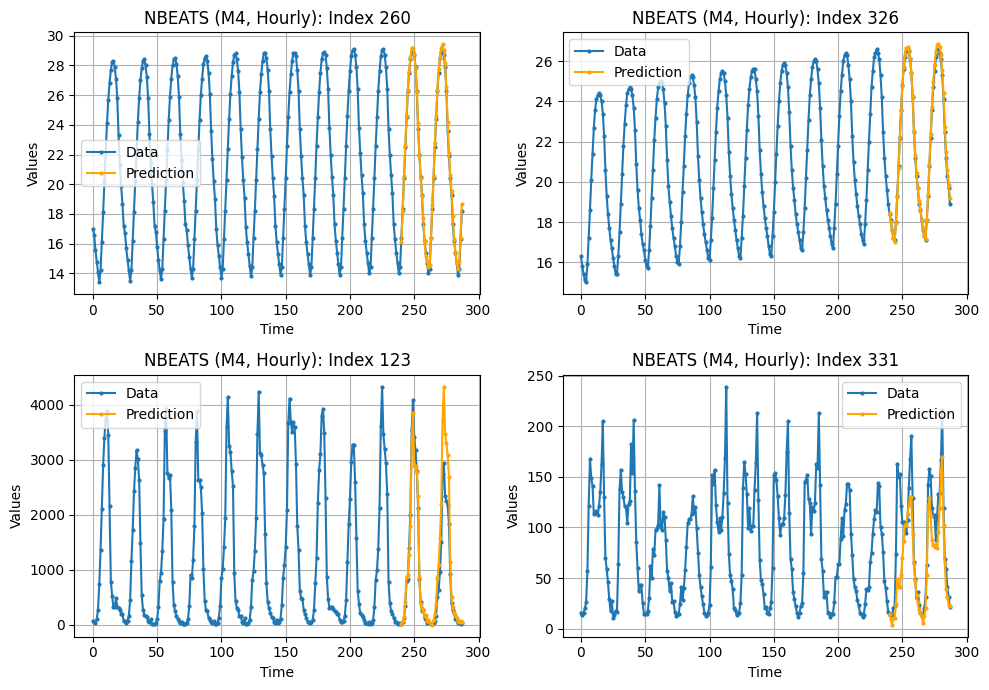

In [44]:
plot_random_sample(pred_hourly, freq='Hourly')

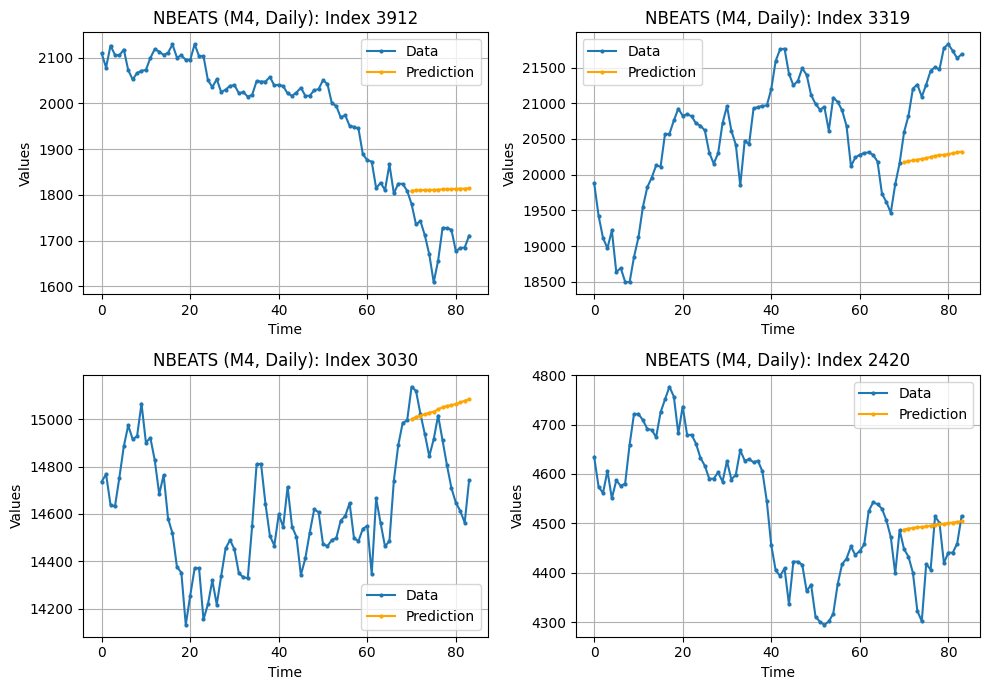

In [52]:
plot_random_sample(pred_daily, freq='Daily')

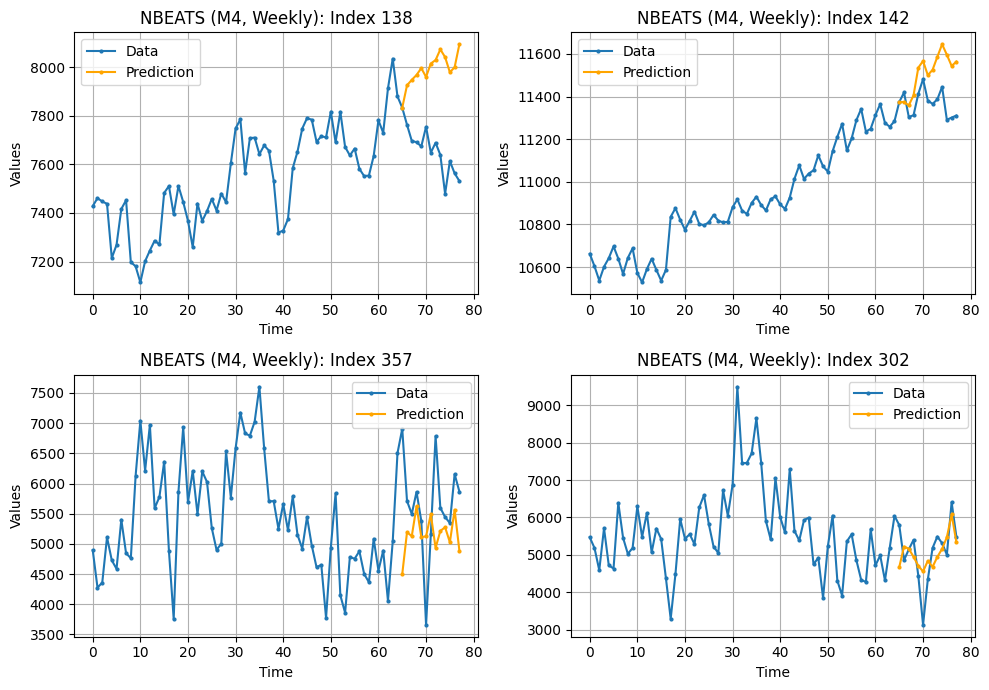

In [48]:
plot_random_sample(pred_weekly, freq='Weekly')

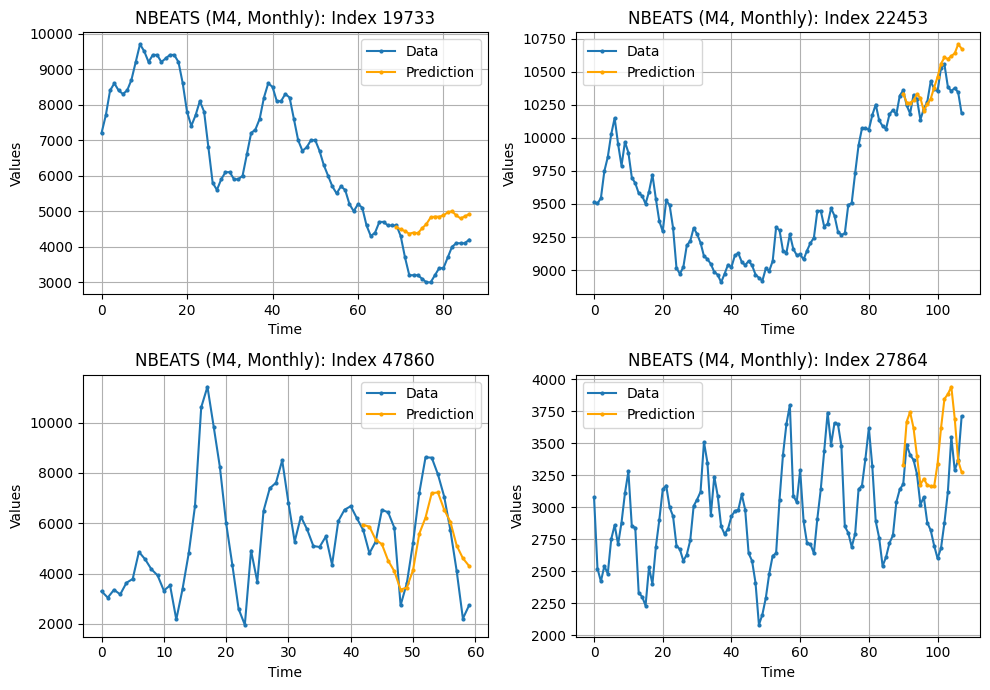

In [49]:
plot_random_sample(pred_monthly, freq='Monthly')

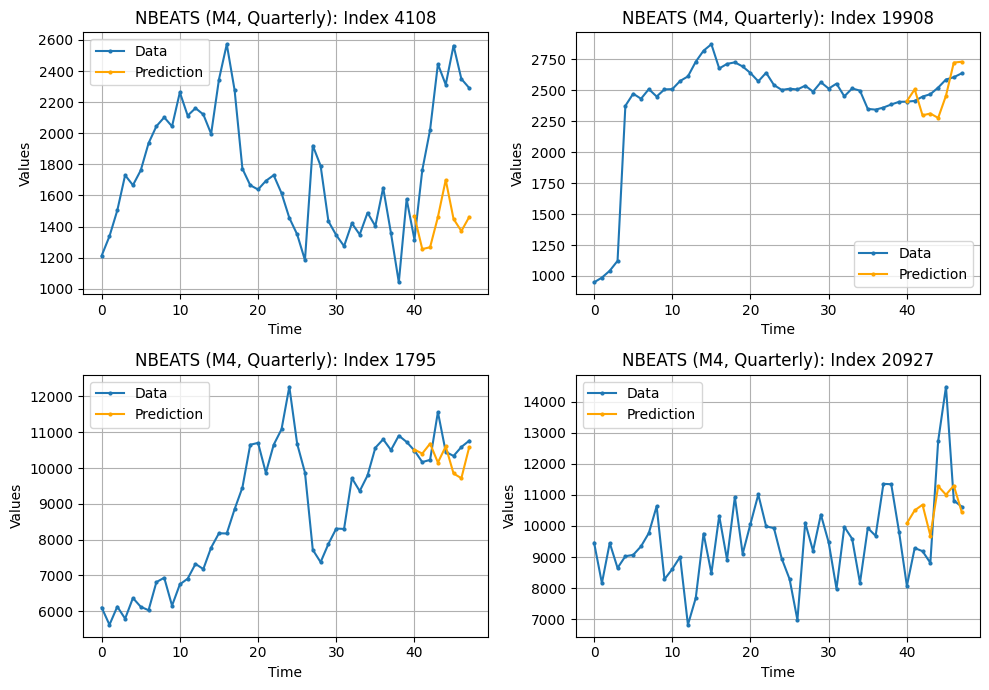

In [51]:
plot_random_sample(pred_quarterly, freq='Quarterly')

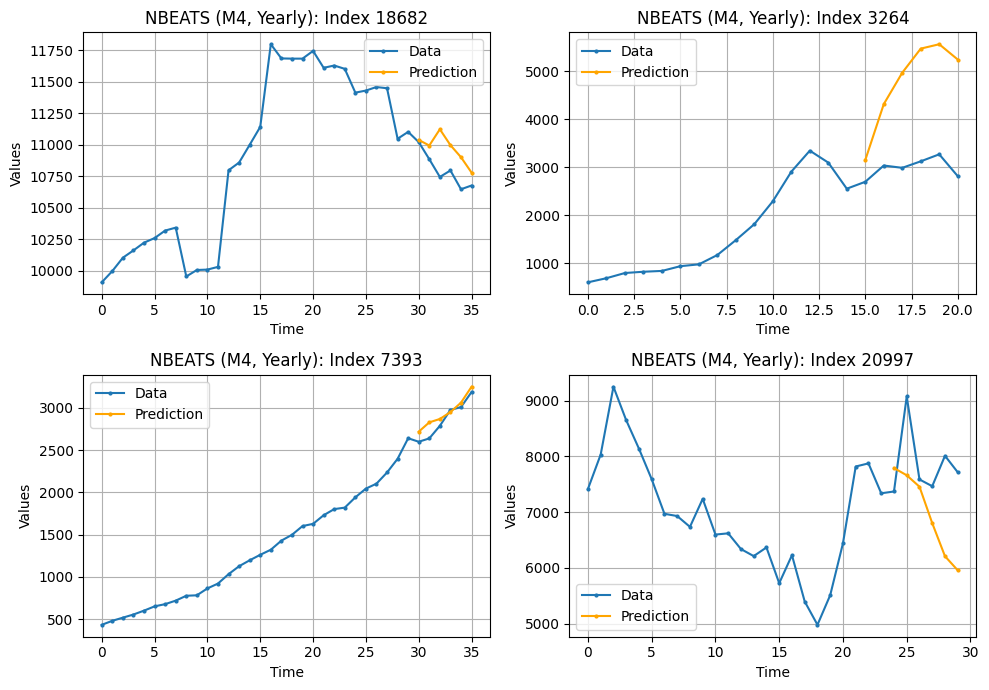

In [50]:
plot_random_sample(pred_yearly, freq='Yearly')